<a href="https://colab.research.google.com/github/minhphan03/AMATH-301-Python-Notebooks/blob/main/interpolation_and_extrapolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import pandas as pd

# Interpolation and Extrapolation
All of the methods we have discussed in the last two lectures have followed a certain philosophy: We wanted to find a curve that came close to all of our data points, but we were more concerned with finding a relatively simple formula than with actually hitting any of the points.  In other words, we were more concerned with avoiding overfitting than with finding a perfect fit.  

This is usually exactly the right approach.  In many scientific disciplines your data comes with enough noise/uncertainty that you cannot hope to find a model that exactly predicts all of it.  If you try to predict every single point exactly correctly, then you will end up drastically overfitting your data and finding a very complicated curve that does not do a good job at predicting new data points or capturing any interesting patterns in the data set.  The most you can do is find a relatively simple model that captures important trends.  

However, there are other situations where we really trust our data points but simply don't have enough of them.  For example, you might be tracking an animal using a GPS collar.  At regular time intervals, these collars report their position via a radio signal.  Modern GPS is extremely accurate, so the position data is often close enough to exact that we can treat our data as perfect.  The main constraint on tracking is not accuracy, but battery life.  As you might imagine, it is difficult to change the battery on a collar/tag attached to a migrating bird or a wild python.  To extend the battery life, these collars might only report their position every few hours.  A similar situation arises in computer graphics.  For example, you might use motion capture technology to track the position of an actors joints (or set the positions of these joints when making an animation).  The position data from this technology are quite accurate, but we need to fill in data for the rest of the body.  Such situations also arise in a purely mathematical context.  For instance, when solving a partial differential equation numerically, you typically only find the solution at regularly spaced grid points instead of an arbitrary $(x, y)$.  You can often ensure that your solutions are highly accurate at those grid points, but it is still important to know how the solution behaves in between them.  

In all of these situations, we want to find a function that hits every one of our data points exactly.  We will then use that function to predict values in between (or possibly outside of) those from our data.  Predicting values in between your existing data points is known as interpolation, while predicting values outside of the range of your existing data points is known as extrapolation.  

For mathematical convenience, we will only consider 1-dimensional data like the data sets in `data1.csv`, `data2.csv` and `data3.csv`.  That is, we will assume that we have a vector of $x$ values $\mathbf{x} = [x_1, x_2, \dotsc, x_n]$ and a corresponding vector of $y$ values $\mathbf{y} = [y_1, y_2, \dotsc, y_n]$.  We will also assume that the $x$'s are in order, so $x_1 < x_2 < \cdots < x_n$.  The $y$ data is of the form $y_k = f(x_k)$, but we do not know the function $f$.  Our goal is to find a function $f$ so that $f(x_k)$ does actually equal $y_k$ for each one of our data points and then use that function to predict $f(x)$ at some other $x$ value.  When $x_1 < x < x_n$, we call this *interpolation*, but when $x < x_1$ or $x > x_n$ then we call this *extrapolation$.  

We will focus on interpolation for most of this lecture, and briefly discuss the challenges with extrapolation at the end.  As an example, we will use the data from `data4.csv`.  

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Week6_data4.csv to Week6_data4.csv


In [ ]:
df = pd.read_csv('Week6_data4.csv')

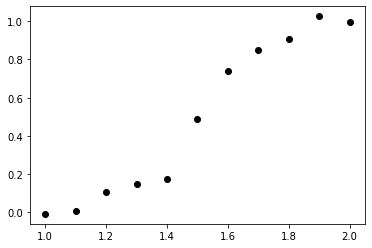

In [ ]:
data = np.genfromtxt('Week6_data4.csv', delimiter=',')
x = data[0, :]
y = data[1, :]
n = x.size
plt.plot(x, y, 'ko')

## Interpolation
We already know one (quite bad) method of interpolation.  We could fit an $(n-1)$st degree polynomial to our data and then use that polynomial to predict other points.  With the data from `data4.csv`, this would mean 

In [ ]:
coeffs = np.polyfit(x, y, n - 1)
xplot = np.linspace(1, 2, 1000)
yplot = np.polyval(coeffs, xplot)

The last line, where we call `polyval`, is an interpolation.  We are interpolating our data at all of the $x$ values in `xplot`.  To visualize this, we can plot our interpolated values alongside the original data.  

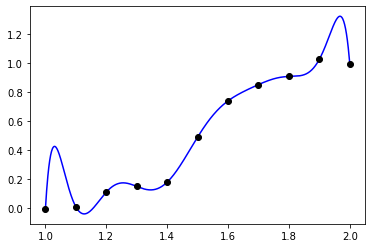

In [ ]:
plt.plot(xplot, yplot, 'b', x, y, 'ko')

Because our data set is relatively small (i.e., $n$ is only 11), this was not a complete disaster, but it is not a particularly good strategy.  For instance, it is not clear why we would want our interpolation to include large spikes near 1.05 or 1.95.  As a general rule, this method is only an acceptable idea if you have six data points or fewer.  With any more points, finding a high order polynomial that matches every data point will only lead to problems.  However, if you only have a few data points (two to four is ideal, but you can get away with five or six), then a polynomial fit like this often provides a very good interpolation.  

The key idea in most interpolation methods is to divide our data into small subsets of points and fit each subset separately.  The simplest method is to divide our data up into pairs.  If you want to interpolate at a point $x$, then you find two data points closest to $x$ (i.e., $x_k < x < x_{k+1}$) and then fit a line between those two points.  This is called a *linear interpolation*.  We could implement it with the following code: 

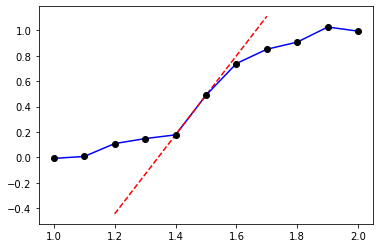

In [ ]:
for k in range(n - 1):
    # Choose two neighboring points
    x_subset = np.array([x[k], x[k + 1]])
    y_subset = np.array([y[k], y[k + 1]])
    # Find the line between x[k] and x[k+1]
    coeffs = np.polyfit(x_subset, y_subset, 1)
    # Choose x's between x[k] and x[k+1] to interpolate at
    xplot = np.linspace(x[k], x[k + 1], 1000)
    # Use polyval to interpolate
    yplot = np.polyval(coeffs, xplot)
    # Add to our graph
    plt.plot(xplot, yplot, 'b')
    # Add more of one line for visualization purposes
    if k == 4:
        xplot = np.linspace(x[k] - 0.2, x[k + 1] + 0.2, 1000)
        yplot = np.polyval(coeffs, xplot)
        plt.plot(xplot, yplot, 'r--')

plt.plot(x, y, 'ko')

Note that this is actually the default method that python uses to graph data, so the command `plt.plot(x, y, 'b')` would have produced the same graph (without the extra dotted lines).  There is also a predefined function in the package `scipy.interpolate` that finds a linear interpolation like this.  The function is called `interp1d`.  It takes two arguments, an array of x data and an array of y data, and it returns a function that calculates the linear interpolation at any given x value.  For example, 

In [ ]:
interp_func = scipy.interpolate.interp1d(x, y)
print(interp_func(1.45))

0.3327491307746085


We could therefore make the same plot as above (without the extra dotted lines) with the code

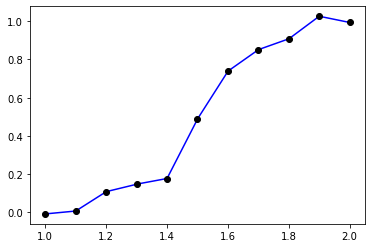

In [ ]:
xplot = np.linspace(1, 2, 1000)
yplot = interp_func(xplot)
plt.plot(xplot, yplot, 'b', x, y, 'ko')

There is no real reason to stop at two data points.  We could also pick the nearest three or four (or more, but that starts to risk overfitting) data points.  For example, we could pick the four closest data points and then fit a cubic to those points.  For most $x$ values, this means that we would choose data points $x_k < x_{k+1} < x < x_{k+2} < x_{k+3}$, but at the far left and right (i.e., to the left of $x_2$ and to the right of $x_{n-1}$), we need to choose slightly different sets of points.  We could accomplish this with the following code: 

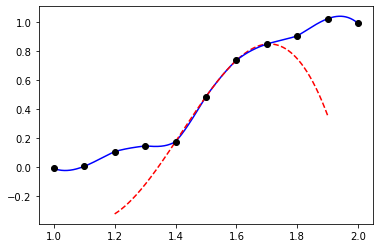

In [ ]:
for k in range(n - 3):
    # Choose four neighboring points
    x_subset = np.array([x[k], x[k + 1], x[k + 2], x[k + 3]])
    y_subset = np.array([y[k], y[k + 1], y[k + 2], y[k + 3]])
    # Find the cubic fit between these four points
    coeffs = np.polyfit(x_subset, y_subset, 3)
    # Choose x's between x[k + 1] and x[k + 2] to interpolate at
    xplot = np.linspace(x[k + 1], x[k + 2], 1000)
    # Use polyval to interpolate
    yplot = np.polyval(coeffs, xplot)
    # Add to our graph
    plt.plot(xplot, yplot, 'b')
    # Add more of one line for visualization purposes
    if k == 4:
        xplot = np.linspace(x[k] - 0.2, x[k + 3] + 0.2, 1000)
        yplot = np.polyval(coeffs, xplot)
        plt.plot(xplot, yplot, 'r--')
# Now handle the first and last interval separately
x_subset = x[:4]
y_subset = y[:4]
coeffs = np.polyfit(x_subset, y_subset, 3)
xplot = np.linspace(x[0], x[1], 1000)
yplot = np.polyval(coeffs, xplot)
plt.plot(xplot, yplot, 'b')

x_subset = x[-4:]
y_subset = y[-4:]
coeffs = np.polyfit(x_subset, y_subset, 3)
xplot = np.linspace(x[-2], x[-1], 1000)
yplot = np.polyval(coeffs, xplot)
plt.plot(xplot, yplot, 'b')

plt.plot(x, y, 'ko')

This is called a *cubic interpolation*, but it is probably not what you will find if you look up cubic interpolations online, because our version has a problem.  It's hard to tell unless you zoom in quite close, but our interpolation function is not smooth: There are still sharp corners at each data point.  We are often interested in finding smooth interpolations without any such corners.  There are several methods for finding smooth interpolations, and almost all of them are based ont eh same idea: We are creating our best fit cubic using four data points, but it only actually has to match two of them.  (If you zoom in on the graph above, you can see that the dotted red line, which is one of our best fit cubics, exactly matches the four neighboring data points at $x = 1.4$, $x = 1.5$, $x = 1.6$ and $x = 1.7$, but we only used that curve to interpolate between $x = 1.5$ and $x = 1.6$.  Since we don't actually care if the cubic matches the data points at $x = 1.4$ or $x = 1.7$, we could instead insist that our cubic had the correct derivatives at the two points we actually care about.  The algebra involved gets somewhat complicated, so we will skip it here, but such an approach is called a *cubic spline*.  The `interp1d` function can also find cubic splines, but not the non-smooth cubic interpolation that we did above.  We could find a cubic spline interpolation with the following code: 

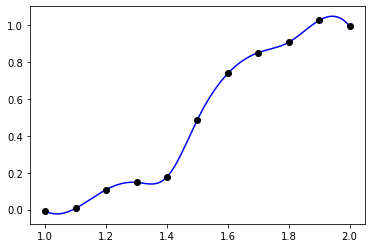

In [ ]:
xplot = np.linspace(1, 2, 1000)
interp_func = scipy.interpolate.interp1d(x, y, kind='cubic')
yplot = interp_func(xplot)
plt.plot(xplot, yplot, 'b', x, y, 'ko')

If you zoom in on this graph, you will see that it is actually smooth.  (Technically speaking, the cubic spline is $C^2$, so its first and second derivatives are continuous, but the third derivative is discontinuous at each data point.)

Linear interpolations and cubic splines are two of the most common methods for interpolation, but the interp1 function includes several other methods.  Most are variations of the cubic spline with different orders or different ways of enforcing smoothness.  In this class, we will only use the default (linear) interpolation or cubic splines.  

## Extrapolation
So far, we have only focused on interpolating values.  That is, we have been interested in finding $f(x)$ when $x$ is in between some of our data points.  In principle, there isn't anything stopping us from using the same techniques to extrapolate data.  For instance, we could use a linear interpolation or a spline to predict $f(x)$ even if $x > x_n$ or $x < x_1$.  The `interp1d` function allows you to do this by adding the extra option `fill_value='extrapolate'` at the end of the function call.  For example, we could predict $f(5)$ with the code

In [ ]:
interp_func = scipy.interpolate.interp1d(x, y, fill_value='extrapolate')
print(interp_func(5))

0.017616516297765505


or

In [ ]:
interp_func = scipy.interpolate.interp1d(x, y, kind='cubic', fill_value='extrapolate')
print(interp_func(5))

-1581.378832105127


In general, this is a bad idea.  To see why, let's extrapolate at a lot of different $x$ values and plot our predictions.  

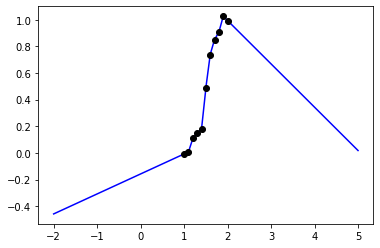

In [ ]:
xplot = np.linspace(-2, 5, 1000)
interp_func = scipy.interpolate.interp1d(x, y, fill_value='extrapolate')
yplot = interp_func(xplot)
plt.plot(xplot, yplot, 'b', x, y, 'ko')

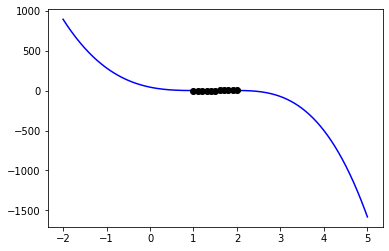

In [ ]:
interp_func = scipy.interpolate.interp1d(x, y, kind='cubic', fill_value='extrapolate')
yplot = interp_func(xplot)
plt.plot(xplot, yplot, 'b', x, y, 'ko')

Which of these is "less bad" is a matter of taste, but it is clear that neither has done a particularly good job of capturing any interesting patterns in our data.  

As a general rule, you shouldn't use any interpolation method for extrapolation if your new $x$ value is farther away than the typical spacing between your data points.  Since our $x$'s are each 0.1 apart, this means that we shouldn't be using `interp1d` to extrapolate for any $x < 0.9$ or $x > 2.1$.  Even within those limits, your extrapolated values will have as much to do with your chosen method as with the original data set.  

The problem isn't really with our methods; it's that extrapolation is hard.  The only real way to extrapolate well is to have some outside knowledge of what function $f(x)$ fits your data.  For instance, if you know that your data really are linear then you should use the methods from lecture 17 to find a best fit line for your data and then use that line to extrapolate.  Likewise, if you know that your data really are exponential, you should use the methods from lecture 18 to find a best fit exponential curve for your data and then use that curve to extrapolate.  Simply put, there is no one size fits all extrapolation method.  